In [40]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy.stats import multivariate_normal
from math import sqrt

In [33]:
n_dim_state = 2 # two states
n_dim_obs = 2 # two observations
transition_matrices = np.array([[0.9, 0.1],[0.3, 0.65]])
observation_matrices = np.array([[1.1, 0.2], [0.1, 0.95]])
mean = 0
std_q = sqrt(0.4)
std_r = sqrt(0.01)
transition_covariance = np.eye(n_dim_state)
transition_covariance = std_q * transition_covariance
observation_covariance = np.eye(n_dim_obs)
observation_covariance = std_r * observation_covariance

In [34]:
class MyKalmanFilter:
    """
    Class that implements the Kalman Filter
    """
    def __init__(self, n_dim_state=2, n_dim_obs=2):
        """
        @param n_dim_state: dimension of the laten variables
        @param n_dim_obs: dimension of the observed variables
        """
        self.n_dim_state = n_dim_state
        self.n_dim_obs = n_dim_obs
        self.transition_matrices = np.eye(n_dim_state) # -- A
        self.transition_offsets = np.zeros(n_dim_state)
        self.transition_covariance = np.eye(n_dim_state) # -- Gamma
        self.observation_matrices = np.eye(n_dim_obs, n_dim_state) # -- C
        self.observation_covariance = np.eye(n_dim_obs) # -- Sigma
        self.observation_offsets = np.zeros(n_dim_obs)
        self.initial_state_mean = np.zeros(n_dim_state)
        self.initial_state_covariance = np.eye(n_dim_state)
        
    def sample(self, n_timesteps, initial_state=None, random_seed=None):
        """
        Method that gives samples
        @param initial_state: numpy array whose length == self.n_dim_state
        @param random_seed: an integer, for test purpose
        @output state: a 2d numpy array with dimension [n_timesteps, self.n_dim_state]
        @output observation: a 2d numpy array with dimension [n_timesteps, self.n_dim_obs]
        """
        # Set initial states and seed
        if initial_state is None:
            initial_state = self.initial_state_mean
        if random_seed is not None:
            np.random.seed(random_seed)
        
        # Produce samples
        latent_state = []
        observed_state = []
        current_latent_state = initial_state
        for t in range(n_timesteps):
            # The first latent state is set to the initial state:
            if t == 0:
                latent_state.append(current_latent_state)
            # Otherwise, use transition_matrices and transition_covariance to calculate the next latent state:
            else:
                latent_state.append(
                    self.transition_matrices @ current_latent_state + 
                    np.random.multivariate_normal(
                        np.zeros(self.n_dim_state), 
                        self.transition_covariance))
                current_latent_state = latent_state[-1]
            # Use observation_matrices and observation_covariance to calculate next observed state
            observed_state.append(
                self.observation_matrices @ current_latent_state + 
                np.random.multivariate_normal(
                    np.zeros(self.n_dim_obs), 
                    self.observation_covariance))

        return np.array(latent_state), np.array(observed_state)
    
    def filter(self, X):
        """
        Method that performs Kalman filtering
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: filtered_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: filtered_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """
        
        # validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim == self.n_dim_obs
        
        # create holders for outputs
        filtered_state_means = np.zeros( (n_example, self.n_dim_state) )
        filtered_state_covariances = np.zeros( (n_example, self.n_dim_state, self.n_dim_state) )
        
        #############################
        # TODO: implement filtering #
        #############################
         
        current_mean = self.initial_state_mean.copy()
        current_covariance = self.initial_state_covariance.copy()
        filtered_state_means[0] = current_mean
        filtered_state_covariances[0] = current_covariance
        
        #self.p_n_list = np.zeros((n_example, self.n_dim_obs, self.n_dim_obs))
        
        # Loop forward up from time t_1 to time t_n, having set t_0 to the initial values of the latent variables. 
        for i in range(1, n_example):

            #1. Prediction step.
            predicted_mean = self.transition_matrices @ current_mean
            predicted_covariance = self.transition_matrices @ current_covariance  @ self.transition_matrices.T \
                + self.transition_covariance
            
            #2. Projection step.
            projected_mean = self.observation_matrices @ predicted_mean
            projected_covariance = self.observation_matrices @ predicted_covariance @ self.observation_matrices.T \
                + self.observation_covariance
            
            
            #3. Innovation step
            kalman_gain_matrix = predicted_covariance * self.observation_matrices.T @ np.linalg.inv(projected_covariance)
            x_i = X[i]
            innovated_mean = predicted_mean + kalman_gain_matrix @ (x_i - self.observation_matrices  @ predicted_mean)
            innovated_covariance = (np.eye(kalman_gain_matrix.shape[0]) - \
                                    kalman_gain_matrix @ self.observation_matrices) @ predicted_covariance
            
            filtered_state_means[i] = innovated_mean
            filtered_state_covariances[i] = innovated_covariance
            current_mean = filtered_state_means[i]
            current_covariance = filtered_state_covariances[i]
       
        return filtered_state_means, filtered_state_covariances
    
    def smooth(self, X):
        """
        Method that performs the Kalman Smoothing
        @param X: a numpy 2D array whose dimension is [n_example, self.n_dim_obs]
        @output: smoothed_state_means: a numpy 2D array whose dimension is [n_example, self.n_dim_state]
        @output: smoothed_state_covariances: a numpy 3D array whose dimension is [n_example, self.n_dim_state, self.n_dim_state]
        """
        # TODO: implement smoothing
        
        # validate inputs
        n_example, observed_dim = X.shape
        assert observed_dim == self.n_dim_obs
        
        # run the forward path
        mu_list, v_list = self.filter(X)
        
        # create holders for outputs
        smoothed_state_means = np.zeros( (n_example, self.n_dim_state) )
        smoothed_state_covariances = np.zeros( (n_example, self.n_dim_state, self.n_dim_state) )
        
        # We are going to move backward, starting at t_{n-1} and we set up last time step t_n with 
        # the results of the forward pass.
        smoothed_state_means[-1] = mu_list[-1]
        smoothed_state_covariances[-1] = v_list[-1]
    
        #############################
        # TODO: implement smoothing #
        #############################
        
        # We loop backward up to index 0 or time t_0.
        for i in range(n_example - 2, -1, -1):
            
            innovated_mean = mu_list[i]
            innovated_covariance = v_list[i]
            predicted_covariance = self.transition_matrices @ innovated_covariance  @ self.transition_matrices.T \
                + self.transition_covariance
            j_i = innovated_covariance @ self.transition_matrices.T @ np.linalg.inv(predicted_covariance)
            smoothed_mean = innovated_mean + \
                j_i @ (smoothed_state_means[i+1] - self.transition_matrices @ innovated_mean)
            smoothed_covariance = innovated_covariance + \
                j_i @ (smoothed_state_covariances[i+1] - predicted_covariance) @ j_i.T
            
            # Update of estimates of latent variables.
            smoothed_state_means[i] = smoothed_mean
            smoothed_state_covariances[i] = smoothed_covariance
            
            
        return smoothed_state_means, smoothed_state_covariances    
    
    def import_param(self, kf_model):
        """
        Method that copies parameters from a trained Kalman Model
        @param kf_model: a Pykalman object
        """
        need_params = ['transition_matrices', 'observation_matrices', 'transition_offsets', 
                  'observation_offsets', 'transition_covariance', 
                  'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
        for param in need_params:
            setattr(self, param, getattr(kf_model, param))

In [35]:
my_kf = MyKalmanFilter(n_dim_state=n_dim_state, n_dim_obs= n_dim_obs)
my_kf.transition_matrices = transition_matrices
my_kf.transition_covariance = transition_covariance
my_kf.observation_matrices = observation_matrices
my_kf.observation_covariance = observation_covariance

In [38]:
n_timesteps = 20
initial_state_mean = np.zeros(2)
random_seed = np.random.seed(1234)
latent_states, observed_states = my_kf.sample(n_timesteps, initial_state_mean, random_seed)

In [67]:
# Data Visualiztion
def plot_kalman(x,y,nx=None,ny=None,kx=None,ky=None, plot_type="r-", label=None):
    """
    Plot the trajectory
    """
    fig, ax = plt.subplots()
#    if kx is not None and ky is not None:
 #       plt.plot(x,y,'g-',kx,ky, plot_type)
        #plt.plot(x,y,'g-',nx,ny,'b.',kx,ky, plot_type)
  #      plt.plot(kx[0], ky[0], 'or')
   #     plt.plot(kx[-1], ky[-1], 'xr')
    #else:
    plt.plot(x,y,'g-')
        #plt.plot(x,y,'g-',nx,ny,'b.')

    plt.xlabel('X position')
    plt.ylabel('Y position')
    #plt.title('Parabola')
    
    #if kx is not None and ky is not None and label is not None:
    #    plt.legend(('true','measured', label))
    #else:
    #    plt.legend(('true','measured'))
    
    return fig
    
def visualize_line_plot(data, xlabel, ylabel, title):
    """
    Function that visualizes a line plot
    """
    plt.plot(data[:,0], data[:,1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

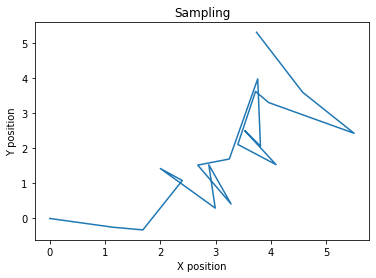

In [72]:
visualize_line_plot(latent_states, "X position", "Y position", "Sampling")